In [ ]:
import json

import pandas as pd

import wandb

api = wandb.Api()

runs = api.runs("liac/GOSyBench-eval")

summary_list, config_list = [], []
for run in runs:
    summary_list.append(run.summary._json_dict)
    cf = {k: v for k, v in run.config.items() if not k.startswith("_")}
    cf["run_id"] = run.id
    config_list.append(cf)

runs_df = pd.DataFrame(
    {
        "summary": summary_list,
        "config": config_list,
    }
)


def get_tables(run_id):
    with wandb.init() as run:
        artifact = run.use_artifact(
            f"liac/GOSyBench-eval/run-{run_id}-Metrics:v0", type="run_table"
        )
        artifact_dir = artifact.download()
        print(artifact_dir)

        dfjson = json.load(open(artifact_dir + f"/Metrics.table.json"))
        df = pd.DataFrame(dfjson["data"], columns=dfjson["columns"])
    return df


tables = []
for run in runs_df.iterrows():
    run_id = run[1]["config"]["run_id"]
    print(run_id)
    df = get_tables(run_id)
    df["method"] = run[1]["config"]["method"]
    df["run_id"] = run_id
    tables.append(df)

In [53]:
df = pd.concat(tables).reset_index(drop=True)

df = pd.concat([df, pd.DataFrame(df["Metrics"].to_dict()).T], axis=1)
df = df.drop(columns=["Metrics"])


def decomp_method(x):
    return pd.Series(x.split("_")[1:], index=["llm", "vision", "select"])


df = pd.concat([df["method"].apply(decomp_method), df], axis=1)
df.sample(4)

,llm,vision,select,Task,method,run_id,local_sim_in,local_sim_out,path_sim_in,path_sim_out,ploc_sim_in,ploc_sim_out
5,gpt4t,vision,,jacs.0c00308,le_gpt4t_vision_,wtunkr0n,0.088198,0.689516,0.036985,0.296765,0.087108,0.367647
51,gpt4t,text,,jacs.0c00308,le_gpt4t_text_,i0cx992t,0.521004,0.582879,0.190184,0.350339,0.350755,0.471875
165,gpt35,text,select,jacs.7b06055,le_gpt35_text_select,4tt38wjh,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
48,gpt4t,text,,jacs.7b00807,le_gpt4t_text_,i0cx992t,0.346114,0.305421,0.062347,0.122646,0.103189,0.207547


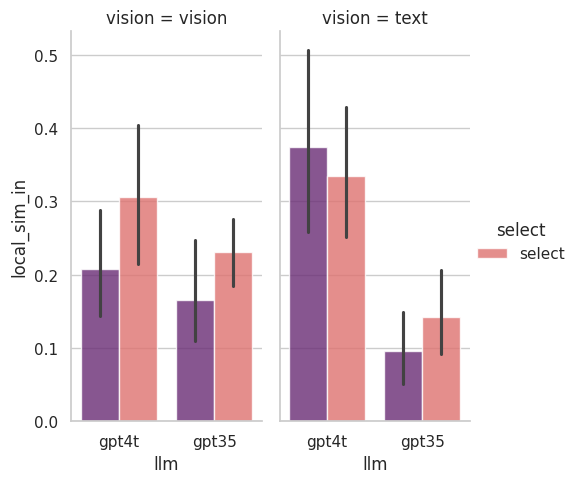

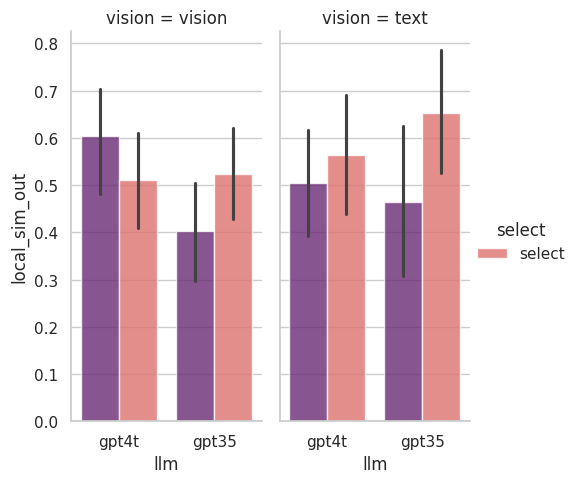

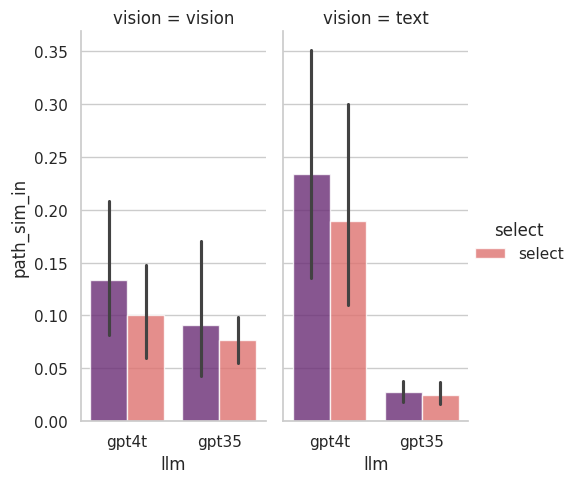

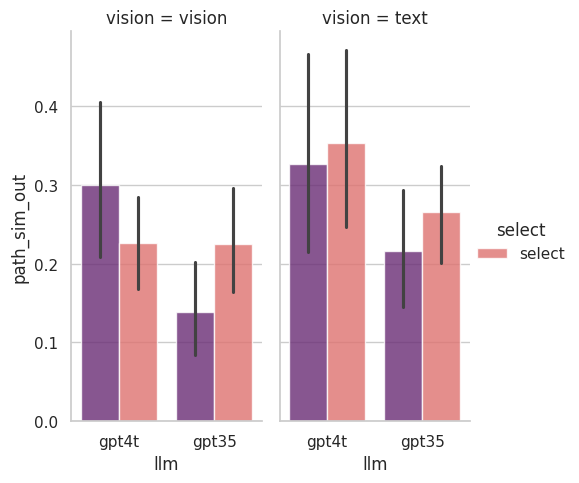

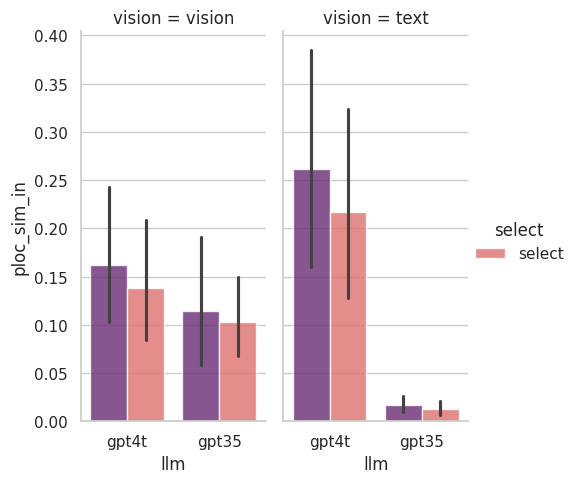

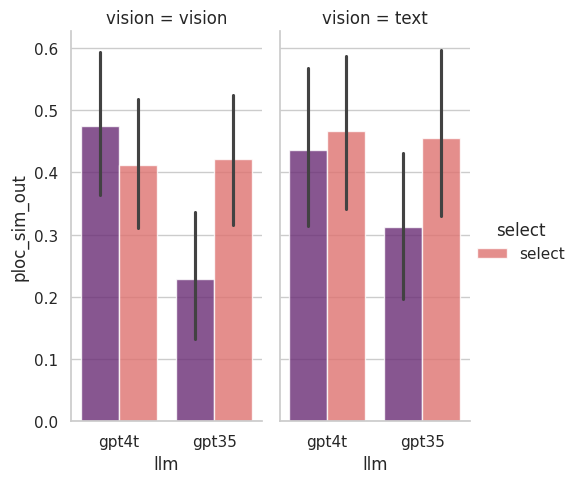

In [70]:
import seaborn as sns

sns.set_theme(style="whitegrid")


def make_plot(metric, kind="bar"):
    if kind == "bar":
        sns.catplot(
            x="llm",
            y=metric,
            hue="select",
            col="vision",
            data=df,
            height=5,
            kind=kind,
            aspect=0.5,
            alpha=0.8,
            palette="magma",
        )
    elif kind == "strip":
        sns.catplot(
            x="llm",
            y=metric,
            hue="select",
            col="vision",
            data=df,
            height=5,
            kind=kind,
            aspect=0.5,
            size=7,
            alpha=0.8,
            palette="magma",
        )


for metric in df.columns[6:]:
    make_plot(metric)

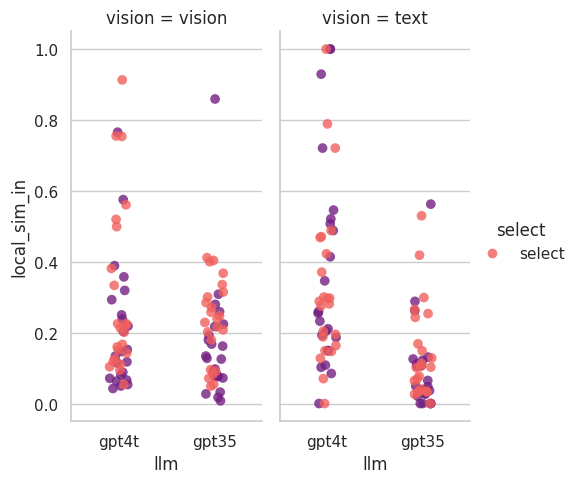

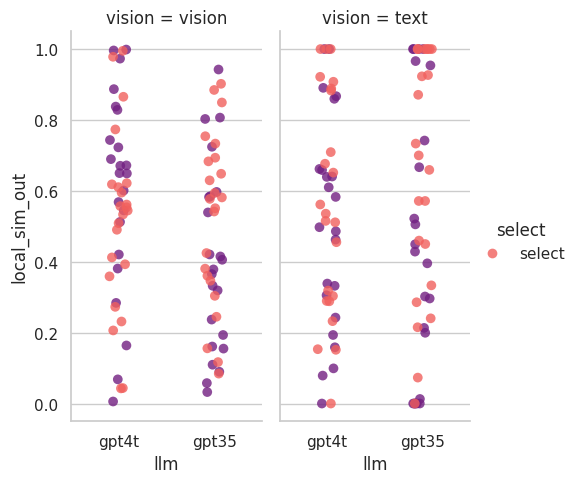

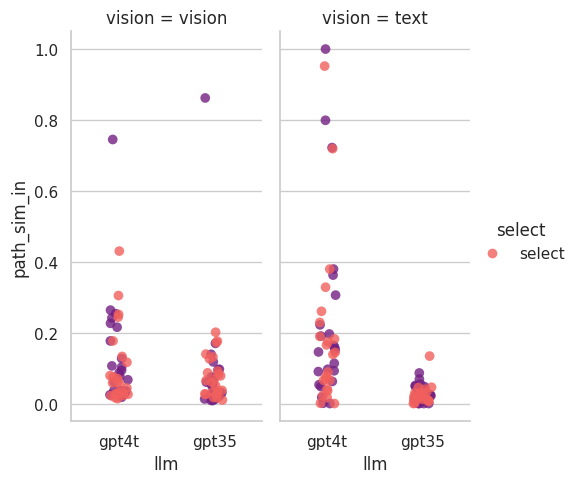

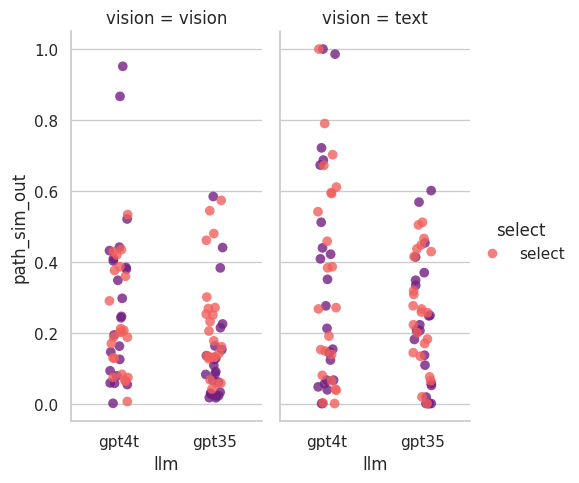

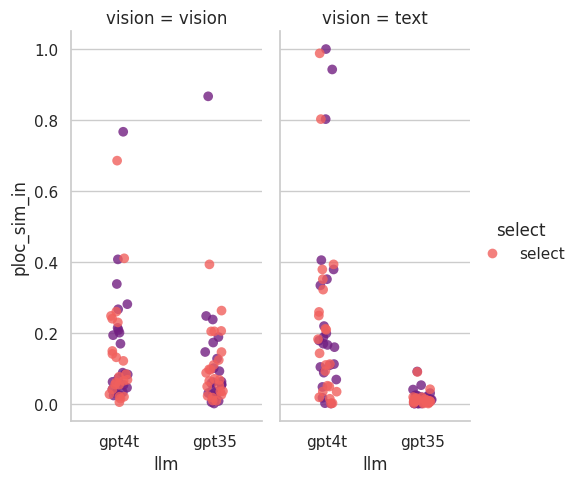

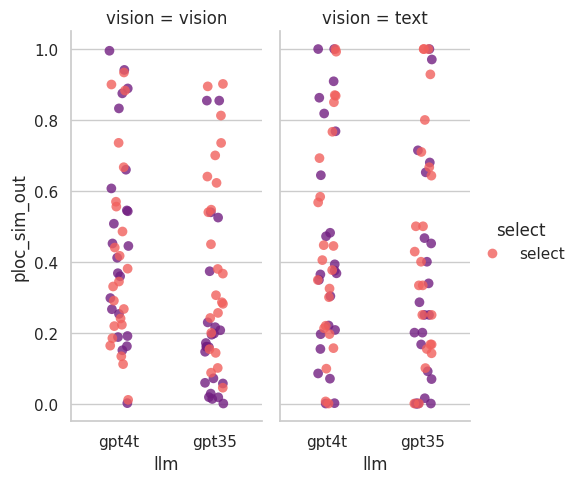

In [71]:
for metric in df.columns[6:]:
    make_plot(metric, kind="strip")